In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
# import particles 
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Input, Lambda, Layer
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Build model

In [3]:
a = tf.Variable(np.ones(512), trainable=False)

In [28]:
dropout = DropoutLayer(512)

In [29]:
b = np.zeros(512, dtype='float32')
dropout.update(b)

In [82]:
input_dim = 2
latent_dim = 512
output_dim = 2

class DropoutLayer(Layer):
    def __init__(self, name, latent_dim=latent_dim):
        super(DropoutLayer, self).__init__(name=name)
        self.mask = tf.Variable(np.ones(latent_dim), dtype='float32', trainable=False)
    def call(self, inputs):
        return inputs * self.mask
    def update(self, mask):
        assert mask.shape == self.mask.shape, f"new mask shape should be {self.mask.shape} but giving {mask.shape}"
        self.mask = tf.Variable(mask)
        self.mask.assign(mask)
    def get(self):
        return self.mask.numpy()
    # may integrate SMC in the future

In [86]:
class MyModel(Model):
    def __init__(self, name):
        super(MyModel, self).__init__(name=name)
        self.dense1 = Dense(latent_dim, activation='relu', name='dense_1')
        self.dense2 = Dense(latent_dim, activation='relu', name='dense_2')
        self.dense3 = Dense(output_dim, name='dense_3')
        self.dropout = DropoutLayer(latent_dim=latent_dim, name='dropout')
        
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dropout(x)
        x = self.dense3(x)
        return x
    
    def update_dropout_mask(self, mask):
        self.dropout.update(mask)
        
    def get_dropout_mask(self):
        return self.dropout.get()
    
    # override summary due to https://stackoverflow.com/questions/55235212/model-summary-cant-print-output-shape-while-using-subclass-model
    def summary(self):
        x = Input(shape=(2), name='input')
        model = Model(inputs=[x], outputs=self.call(x), name=self.name)
        return model.summary()
        
model = MyModel('Two-Link-Arm')

In [87]:
model.summary()

Model: "Two-Link-Arm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536      
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout (DropoutLayer)      (None, 512)               512       
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 265,730
Trainable params: 265,218
Non-trainable params: 512
_________________________________________________________________


In [8]:
pretrained = tf.keras.models.load_model('two_link_arm_pretrained_M', compile=False)

TypeError: __init__() got an unexpected keyword argument 'reduction'

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.losses.MeanAbsoluteError()])

# pretraining

In [10]:
loaded = np.load('./two_link_arm_pretraining_data.npz')
# print(np.array_equal(angles , loaded['x']))
# print(np.array_equal(positions , loaded['y']))
angles = loaded['x']
positions = loaded['y']

In [11]:
def train_test_split_reptile(x,y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(np.swapaxes(x.reshape(n_tasks, n_episode, -1),0,1), np.swapaxes(y.reshape(n_tasks, n_episode, -1),0,1), test_size=test_ratio, shuffle = False)
    return x_train.reshape(-1,2), x_test.reshape(-1,2), y_train.reshape(-1,2),y_test.reshape(-1,2)

In [12]:
import pickle

In [13]:
test_ratio = 0.1

In [ ]:
# multitask
x_train, x_test, y_train, y_test = train_test_split(angles, positions, test_size=test_ratio, random_state=666)
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))
model.save('./two_link_arm_pretrained_M.model')
with open('./two_link_arm_pretrained_M.history','wb') as f:
    pickle.dump(history.history, f)
    

Epoch 1/200
1055/1055 [==============================] - 7s 6ms/step - loss: 1.0922 - mean_absolute_error: 0.8233 - val_loss: 0.8864 - val_mean_absolute_error: 0.7278
Epoch 2/200
1055/1055 [==============================] - 5s 5ms/step - loss: 0.7850 - mean_absolute_error: 0.6760 - val_loss: 0.7185 - val_mean_absolute_error: 0.6408
Epoch 3/200
1055/1055 [==============================] - 5s 5ms/step - loss: 0.6546 - mean_absolute_error: 0.6102 - val_loss: 0.6144 - val_mean_absolute_error: 0.5875
Epoch 4/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.5690 - mean_absolute_error: 0.5663 - val_loss: 0.5402 - val_mean_absolute_error: 0.5515
Epoch 5/200
1055/1055 [==============================] - 7s 6ms/step - loss: 0.5133 - mean_absolute_error: 0.5373 - val_loss: 0.4960 - val_mean_absolute_error: 0.5289
Epoch 6/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.4763 - mean_absolute_error: 0.5176 - val_loss: 0.4698 - val_mean_absolute_error: 0.514

In [ ]:
# reptile split data by task
x_train, x_test, y_train, y_test = train_test_split_reptile(angles, positions, test_size=test_ratio)
history = model.fit(x_train, y_train, epochs=200, batch_size=128, validation_data=(x_test, y_test))
model.save('./two_link_arm_pretrained_R.model')
with open('./two_link_arm_pretrained_R.history','wb') as f:
    pickle.dump(history.history, f)
    

Epoch 1/200
1055/1055 [==============================] - 7s 6ms/step - loss: 1.1662 - mean_absolute_error: 0.8551 - val_loss: 0.9560 - val_mean_absolute_error: 0.7632
Epoch 2/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.8701 - mean_absolute_error: 0.7215 - val_loss: 0.7401 - val_mean_absolute_error: 0.6565
Epoch 3/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.7405 - mean_absolute_error: 0.6607 - val_loss: 0.6383 - val_mean_absolute_error: 0.6068
Epoch 4/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.6662 - mean_absolute_error: 0.6260 - val_loss: 0.5738 - val_mean_absolute_error: 0.5742
Epoch 5/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.6193 - mean_absolute_error: 0.6030 - val_loss: 0.5312 - val_mean_absolute_error: 0.5515
Epoch 6/200
1055/1055 [==============================] - 6s 6ms/step - loss: 0.5822 - mean_absolute_error: 0.5842 - val_loss: 0.5015 - val_mean_absolute_error: 0.536

In [34]:
loss = history.history['loss']

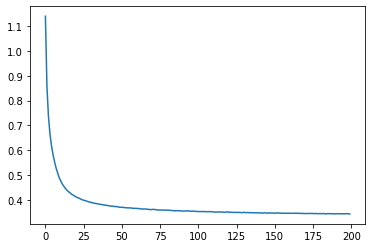

In [35]:
plt.plot(loss)

In [25]:
def plot_model(model):
    loss = model.history.history['loss']
    plt.plot(loss)

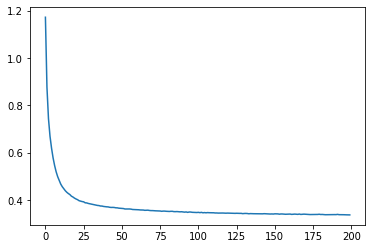

In [26]:
plot_model(model)